In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

INPUT_FILE = "data.csv"
PREVIEW_FILE = "data_preview_head.csv"
FORECAST_OUT = "forecast_results.csv"
MODEL_OUT = "rf_model.joblib"

In [2]:
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Cannot find '{INPUT_FILE}' in the current folder: {os.listdir('.')[:20]}")


encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
last_err = None
for enc in encodings:
    try:
        df = pd.read_csv(INPUT_FILE, encoding=enc, low_memory=False)
        print(f"Loaded '{INPUT_FILE}' with encoding {enc}. Shape: {df.shape}")
        break
    except Exception as e:
        last_err = e
else:
    raise RuntimeError(f"Failed to read '{INPUT_FILE}' with tried encodings. Last error: {last_err}")


df.head(200).to_csv(PREVIEW_FILE, index=False)
print(f"Preview saved to {PREVIEW_FILE} (first 200 rows).")


Loaded 'data.csv' with encoding latin1. Shape: (541909, 8)
Preview saved to data_preview_head.csv (first 200 rows).


In [3]:
print("Columns:", list(df.columns))
print(df.dtypes)
print("\nMissing values (top):")
print(df.isna().sum().sort_values(ascending=False).head(20))

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Missing values (top):
CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64


In [4]:
expected = {
    'date': ['invoice date','invoicedate','date','order_date','orderdate'],
    'quantity': ['quantity','qty','units'],
    'unitprice': ['unitprice','price','unit_price','amount'],
    'invoiceno': ['invoiceno','invoice_no','invoice']
}


def find_col_by_keywords(cols, keywords):
    cols_lower = {c.lower(): c for c in cols}
    for kw in keywords:
        for c_lower, c_orig in cols_lower.items():
            if kw in c_lower:
                return c_orig
    return None

cols = list(df.columns)
DATE_COL = find_col_by_keywords(cols, expected['date'])
QTY_COL = find_col_by_keywords(cols, expected['quantity'])
PRICE_COL = find_col_by_keywords(cols, expected['unitprice'])
INVOICE_COL = find_col_by_keywords(cols, expected['invoiceno'])

print("Detected columns:")
print("  DATE_COL  ->", DATE_COL)
print("  QTY_COL   ->", QTY_COL)
print("  PRICE_COL ->", PRICE_COL)
print("  INVOICE_COL ->", INVOICE_COL)

missing = [name for name, val in [('DATE_COL',DATE_COL), ('QTY_COL',QTY_COL), ('PRICE_COL',PRICE_COL)] if val is None]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please rename your dataset columns or tell me actual column names.")

Detected columns:
  DATE_COL  -> InvoiceDate
  QTY_COL   -> Quantity
  PRICE_COL -> UnitPrice
  INVOICE_COL -> InvoiceNo


In [5]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce', infer_datetime_format=True)
df[QTY_COL] = pd.to_numeric(df[QTY_COL], errors='coerce')
df[PRICE_COL] = pd.to_numeric(df[PRICE_COL], errors='coerce')
df['sales_amount'] = df[QTY_COL] * df[PRICE_COL]

before = len(df)
df = df.dropna(subset=[DATE_COL, 'sales_amount'])
print(f"Dropped {before - len(df)} rows with missing date or sales_amount.")

C:\Users\sathv\AppData\Local\Temp\ipykernel_6172\2901507715.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce', infer_datetime_format=True)


Dropped 0 rows with missing date or sales_amount.


In [6]:
if INVOICE_COL is not None:
    mask_returns = df[INVOICE_COL].astype(str).str.startswith('C', na=False)
    if mask_returns.any():
        removed = mask_returns.sum()
        df = df[~mask_returns]
        print(f"Removed {removed} cancellation rows (Invoice no starts with 'C').")
    else:
        print("No cancellation rows detected by InvoiceNo starting with 'C'.")
else:
    print("Invoice column not detected; skipping cancellation removal.")

Removed 9288 cancellation rows (Invoice no starts with 'C').


In [7]:
df = df.sort_values(by=DATE_COL)
ts_daily = df.set_index(DATE_COL).resample('D')['sales_amount'].sum().rename('sales')
ts_daily = ts_daily.asfreq('D').fillna(0)
print("Daily series:", ts_daily.index.min(), "to", ts_daily.index.max(), "| length:", len(ts_daily))

Daily series: 2010-12-01 00:00:00 to 2011-12-09 00:00:00 | length: 374


In [8]:
df_feat = ts_daily.to_frame()
max_lag = 14

for lag in range(1, max_lag+1):
    df_feat[f'lag_{lag}'] = df_feat['sales'].shift(lag)

df_feat['rolling_7'] = df_feat['sales'].shift(1).rolling(window=7, min_periods=1).mean()
df_feat['dayofweek'] = df_feat.index.dayofweek

df_feat = df_feat.dropna()
print("Feature dataframe shape after lagging:", df_feat.shape)
df_feat.head()

Feature dataframe shape after lagging: (360, 17)


,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_7,dayofweek
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-15,30444.62,45254.73,38006.71,17329.07,0.00,59182.92,53586.18,45389.98,99618.20,54830.46,31774.95,0.00,46943.71,47748.38,58960.79,36964.227143,2
2010-12-16,49352.90,30444.62,45254.73,38006.71,17329.07,0.00,59182.92,53586.18,45389.98,99618.20,54830.46,31774.95,0.00,46943.71,47748.38,34829.175714,3
2010-12-17,45418.33,49352.90,30444.62,45254.73,38006.71,17329.07,0.00,59182.92,53586.18,45389.98,99618.20,54830.46,31774.95,0.00,46943.71,34224.421429,4
2010-12-18,0.00,45418.33,49352.90,30444.62,45254.73,38006.71,17329.07,0.00,59182.92,53586.18,45389.98,99618.20,54830.46,31774.95,0.00,32258.051429,5
2010-12-19,7534.91,0.00,45418.33,49352.90,30444.62,45254.73,38006.71,17329.07,0.00,59182.92,53586.18,45389.98,99618.20,54830.46,31774.95,32258.051429,6


In [9]:
n = len(df_feat)
if n < 20:
    raise ValueError("Not enough rows after feature engineering. Consider reducing max_lag or aggregating weekly.")

test_days = 30 if n > 90 else max(1, int(n * 0.2))
train = df_feat.iloc[:-test_days]
test = df_feat.iloc[-test_days:]

X_train = train.drop(columns=['sales'])
y_train = train['sales']
X_test = test.drop(columns=['sales'])
y_test = test['sales']

print("Train rows:", len(X_train), "Test rows:", len(X_test))

Train rows: 330 Test rows: 30


In [10]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

try:
    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    print("Models trained successfully.")
except MemoryError:
    raise MemoryError("MemoryError: Try reducing n_estimators for RandomForest (e.g., 50) or fit on a smaller dataset.")
except Exception as e:
    raise RuntimeError(f"Model training failed with: {e}")

Models trained successfully.


In [11]:

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true.abs() > 1  # filter near-zero days for MAPE
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-9))) * 100) if mask.any() else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE_filtered': mape}

print("LinearRegression metrics:", metrics(y_test, pred_lr))
print("RandomForest metrics:", metrics(y_test, pred_rf))

LinearRegression metrics: {'MAE': 18863.558502276188, 'RMSE': 31929.393603425255, 'MAPE_filtered': np.float64(25.98237804341937)}
RandomForest metrics: {'MAE': 16432.73884416665, 'RMSE': 31241.77076931163, 'MAPE_filtered': np.float64(22.76991713952907)}


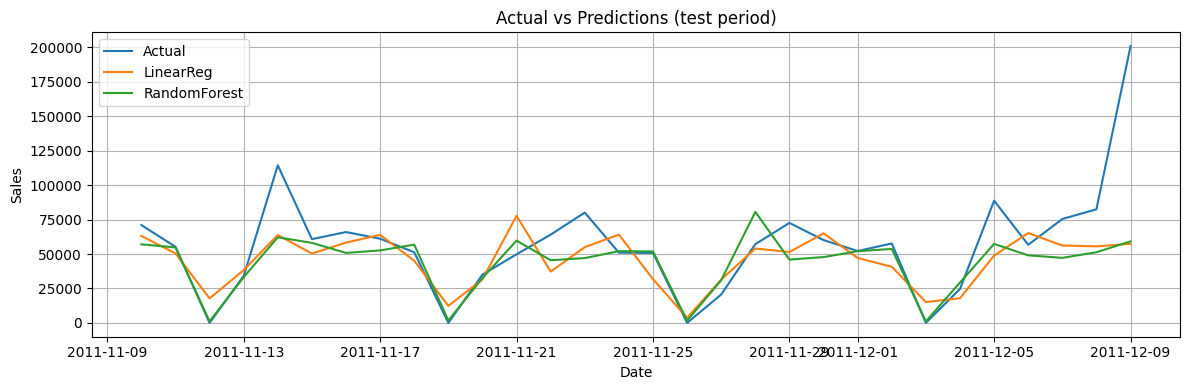

In [12]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_lr, label='LinearReg')
plt.plot(y_test.index, pred_rf, label='RandomForest')
plt.legend(); plt.title("Actual vs Predictions (test period)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.tight_layout()
plt.show()

In [13]:
last_row = df_feat.iloc[-1:].copy()
cur = last_row.copy()
steps = 30
future = []

for i in range(steps):
    Xcur = cur.drop(columns=['sales'])
    ypred = float(rf.predict(Xcur)[0])
    next_date = cur.index[0] + pd.Timedelta(days=1)
    future.append({'date': next_date, 'forecast': ypred})
    # build next features row for subsequent step
    new = {'sales': ypred}
    for lag in range(1, max_lag+1):
        if lag == 1:
            new[f'lag_{lag}'] = cur['sales'].values[0]
        else:
            new[f'lag_{lag}'] = cur[f'lag_{lag-1}'].values[0]
    new['rolling_7'] = float(pd.concat([cur['rolling_7'], pd.Series([cur['sales'].values[0]])]).rolling(window=7, min_periods=1).mean().iloc[-1])
    new['dayofweek'] = next_date.dayofweek
    cur = pd.DataFrame(new, index=[next_date])

future_df = pd.DataFrame(future).set_index('date')
future_df.head(10)

,forecast
date,
2011-12-10,59188.816550
2011-12-11,664.895705
2011-12-12,32906.486795
2011-12-13,62582.609885
2011-12-14,80523.170930
2011-12-15,76082.719810
2011-12-16,51093.981265
2011-12-17,52028.608460
2011-12-18,33526.731660


In [15]:
hist = ts_daily.rename('actual').reset_index()


date_col_name = hist.columns[0]


hist = hist.rename(columns={date_col_name: 'date'})


future_out = future_df.reset_index().rename(columns={'index': 'date'})


combined = pd.merge(hist, future_out, on='date', how='outer').sort_values('date')


combined.to_csv(FORECAST_OUT, index=False)

print("Saved combined historical + forecast to:", FORECAST_OUT)

Saved combined historical + forecast to: forecast_results.csv
